# Causal Bayesian networks for correction of potential bias in ML models

Author: Carl Bylin

 ### Install additional libraries and import necessary packages

In [2]:
# Install additional libraries for causal inference
#!pip install dowhy
#!pip install pgmpy

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import CausalInference
from pgmpy.sampling import BayesianModelSampling

import dowhy
from dowhy import CausalModel
import dowhy.causal_estimators.linear_regression_estimator
from IPython.display import Image, display
import statsmodels.api as sm

import networkx as nx

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Motivating example

This section uses the `pgmpy` library to define a data generating process that we will use to 1) show an example of Simpson's paradox and 2) clarify that causal graphs are often necessary to clearly resolve the problem imposed by Simpson's paradox.

This causal graph assumes a variabl F as the sensitive attribute corresponding to a person being foreigner or local in a specific country.

The variable A is a mediating variable corresponding to the usage of a public employment agency to find work.

The variable J is the target variable and evaluates to 1 if a person was hired for a job or 0 if the person was not hired.

In [4]:
model = BayesianNetwork([('F', 'A'), ('A', 'J'), ('F', 'J')])

`pgmpy` allows us to manually define the conditional probability distributions of each variable in simple cases:

In [5]:
cpd_f = TabularCPD(variable='F',
                   variable_card=2,
                   values=[[0.2],
                           [0.8]],
                   state_names={'F': ['foreigner', 'local']})
cpd_a = TabularCPD(variable='A',
                   variable_card=2,
                   values=[[0.8, 0.2],
                           [0.2, 0.8]],
                   evidence=['F'],
                   evidence_card=[2],
                   state_names={'F': ['foreigner', 'local'], 'A':['agency', 'no agency']})
cpd_j = TabularCPD(variable='J',
                   variable_card=2,
                   values=[[0.75, 0.4, 0.8, 0.6],
                           [0.25, 0.6, 0.2, 0.4]],
                   evidence=['F', 'A'],
                   evidence_card=[2, 2],
                   state_names={'F': ['foreigner', 'local'], 'A':['agency', 'no agency'], 'J': ['hired', 'not hired']})



With this we can print out each of the conditional probability distributions:

In [6]:
print(cpd_f)

+--------------+-----+
| F(foreigner) | 0.2 |
+--------------+-----+
| F(local)     | 0.8 |
+--------------+-----+


In [7]:
print(cpd_a)

+--------------+--------------+----------+
| F            | F(foreigner) | F(local) |
+--------------+--------------+----------+
| A(agency)    | 0.8          | 0.2      |
+--------------+--------------+----------+
| A(no agency) | 0.2          | 0.8      |
+--------------+--------------+----------+


In [8]:
print(cpd_j)

+--------------+--------------+--------------+-----------+--------------+
| F            | F(foreigner) | F(foreigner) | F(local)  | F(local)     |
+--------------+--------------+--------------+-----------+--------------+
| A            | A(agency)    | A(no agency) | A(agency) | A(no agency) |
+--------------+--------------+--------------+-----------+--------------+
| J(hired)     | 0.75         | 0.4          | 0.8       | 0.6          |
+--------------+--------------+--------------+-----------+--------------+
| J(not hired) | 0.25         | 0.6          | 0.2       | 0.4          |
+--------------+--------------+--------------+-----------+--------------+


In [9]:
# To add the CDPs to our defined model
model.add_cpds(cpd_f, cpd_a, cpd_j)

With a model that represents the true data generating process, we can use the model to generate samples. In this case we will use it to create a dataset of randomly generated samples according to the probabilities defined in the model:

In [10]:
# Sample data from the Bayesian Network model
inference = BayesianModelSampling(model)
df = inference.forward_sample(size=100000)

  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
df['Foreigner'] = df['F'].map({'local': 0, 'foreigner': 1})
df['Agency'] = df['A'].map({'no agency': 0, 'agency': 1})
df['Job'] = df['J'].map({'not hired': 0, 'hired': 1})

df = df[['Foreigner', 'Agency', 'Job']]

In [12]:
df.head()

,Foreigner,Agency,Job
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,0
4,0,0,1


Just like in any other EDA task we can print out general proportions found in this dataset:

In [13]:
df.groupby('Foreigner')['Job'].mean().to_frame().round(2).T

Foreigner,0,1
Job,0.64,0.68


This would seem to indicate that foreigners have a higher probability of being hired. But below we will see that if we segment by people who use and don't use a public employment agency we find that in both cases foreigners seem to have a lower probability of bein hired:

In [14]:
df[df['Agency']==1].groupby('Foreigner')['Job'].mean().to_frame().round(2).T

Foreigner,0,1
Job,0.8,0.75


In [15]:
df[df['Agency']==0].groupby('Foreigner')['Job'].mean().to_frame().round(2).T

Foreigner,0,1
Job,0.6,0.39


This is a clear example of Simposn's paradox as the conclusions are reversed if we see the aggregated or segmented data.


In [16]:
tmp = pd.DataFrame()
tmp['P(Job)'] = df.groupby('Foreigner')['Job'].mean().to_frame().round(2)['Job'] 
tmp['P(Job|Agency=1)'] = df[df['Agency']==1].groupby('Foreigner')['Job'].mean().to_frame().round(2)['Job'] 
tmp['P(Job|Agency=0)'] = df[df['Agency']==0].groupby('Foreigner')['Job'].mean().to_frame().round(2)['Job'] 
tmp[['P(Job)','P(Job|Agency=1)','P(Job|Agency=0)']].T

Foreigner,0,1
P(Job),0.64,0.68
P(Job|Agency=1),0.80,0.75
P(Job|Agency=0),0.60,0.39


It is not easy to decide which view to use for this example. For this reason we can analyze the same data but changing the labels and the causal dependency of the variables:

In [17]:
col = df.copy()
col.columns = ['No exercise', 'Sunny', 'Cholesterol']

tmp2 = pd.DataFrame()
tmp2['P(Cholesterol)'] = col.groupby('No exercise')['Cholesterol'].mean().to_frame().round(2)['Cholesterol'] 
tmp2['P(Cholesterol|Sunny=1)'] = col[col['Sunny']==1].groupby('No exercise')['Cholesterol'].mean().to_frame().round(2)['Cholesterol'] 
tmp2['P(Cholesterol|Sunny=0)'] = col[col['Sunny']==0].groupby('No exercise')['Cholesterol'].mean().to_frame().round(2)['Cholesterol'] 
tmp2[['P(Cholesterol)','P(Cholesterol|Sunny=1)','P(Cholesterol|Sunny=0)']].T

No exercise,0,1
P(Cholesterol),0.64,0.68
P(Cholesterol|Sunny=1),0.80,0.75
P(Cholesterol|Sunny=0),0.60,0.39


In [18]:
col = df.copy()
col.columns = ['Exercise', 'Young', 'Cholesterol']

tmp2 = pd.DataFrame()
tmp2['P(Cholesterol)'] = col.groupby('Exercise')['Cholesterol'].mean().to_frame().round(2)['Cholesterol'] 
tmp2['P(Cholesterol|Young=1)'] = col[col['Young']==1].groupby('Exercise')['Cholesterol'].mean().to_frame().round(2)['Cholesterol'] 
tmp2['P(Cholesterol|Young=0)'] = col[col['Young']==0].groupby('Exercise')['Cholesterol'].mean().to_frame().round(2)['Cholesterol'] 
tmp2[['P(Cholesterol)','P(Cholesterol|Young=1)','P(Cholesterol|Young=0)']].T

Exercise,0,1
P(Cholesterol),0.64,0.68
P(Cholesterol|Young=1),0.80,0.75
P(Cholesterol|Young=0),0.60,0.39


For both of the previous examples it becomes easy to decide when to use the aggregated or segmented data. For example, our knowledge about the world tells us that more exercise should not increase cholesterol levels.

Below we will also observe the difference between contitioning and intervening on the mediating variable:

In [19]:
df[(df['Agency']==1)]['Job'].mean()

In [20]:
infer_non_adjust = VariableElimination(model)
print(infer_non_adjust.query(variables=['J'], evidence={'A': 'agency'}, show_progress=False))

+--------------+----------+
| J            |   phi(J) |
+==============+==========+
| J(hired)     |   0.7750 |
+--------------+----------+
| J(not hired) |   0.2250 |
+--------------+----------+


In [21]:
df[(df['Foreigner']==1)&(df['Agency']==1)]['Job'].mean()*df['Foreigner'].mean()+df[(df['Foreigner']==0)&(df['Agency']==1)]['Job'].mean()*(1-df['Foreigner'].mean())

In [22]:
intervention = CausalInference(model)
print(intervention.query(variables=['J'], do={'A': 'agency'}, show_progress=False))

+--------------+----------+
| J            |   phi(J) |
+==============+==========+
| J(hired)     |   0.7900 |
+--------------+----------+
| J(not hired) |   0.2100 |
+--------------+----------+


In [23]:
print(intervention.query(variables=['J'], do={'A': 'no agency'}, show_progress=False))

+--------------+----------+
| J            |   phi(J) |
+==============+==========+
| J(hired)     |   0.5600 |
+--------------+----------+
| J(not hired) |   0.4400 |
+--------------+----------+


## Intervention calculus for Bayesian networks

This section serves as a more detailed example on how d-separation works

In this case S stands from Smoke, A for Alarm, F for Firefighters and E for Evacuation.

Smoke causes the alarm to sound which in turn causes both people present in the building to evacuate and firefighters to be called.

In [24]:
model = BayesianNetwork([('S', 'A'), ('A', 'F'), ('A', 'E')])

In [25]:
cpd_s = TabularCPD(variable='S',
                   variable_card=2,
                   values=[[0.95],
                           [0.05]],
                   state_names={'S': ['smoke', 'no smoke']})

cpd_a = TabularCPD(variable='A',
                   variable_card=2,
                   values=[[0.95, 0.1],
                           [0.05, 0.9]],
                   evidence=['S'],
                   evidence_card=[2],
                   state_names={'S': ['smoke', 'no smoke'], 'A':['alarm', 'no alarm']})

cpd_f = TabularCPD(variable='F',
                   variable_card=2,
                   values=[[0.98, 0.05],
                           [0.02, 0.95]],
                   evidence=['A'],
                   evidence_card=[2],
                   state_names={'A':['alarm', 'no alarm'], 'F': ['firefighter', 'no firefighter']})

cpd_e = TabularCPD(variable='E',
                   variable_card=2,
                   values=[[0.96, 0.01],
                           [0.04, 0.99]],
                   evidence=['A'],
                   evidence_card=[2],
                   state_names={'A':['alarm', 'no alarm'], 'E': ['evacuation', 'no evacuation']})


In [26]:
model.add_cpds(cpd_s, cpd_a, cpd_f, cpd_e)

In [27]:
# Sample data from the Bayesian Network model
sampler = BayesianModelSampling(model)
df = sampler.forward_sample(size=100000)

  0%|          | 0/4 [00:00<?, ?it/s]

In [28]:
df['Smoke'] = df['S'].map({'no smoke': 0, 'smoke': 1})
df['Alarm'] = df['A'].map({'no alarm': 0, 'alarm': 1})
df['Firefighter'] = df['F'].map({'no firefighter': 0, 'firefighter': 1})
df['Evacuation'] = df['E'].map({'no evacuation': 0, 'evacuation': 1})

df = df[['Smoke', 'Alarm', 'Firefighter', 'Evacuation']]

df.head()

,Smoke,Alarm,Firefighter,Evacuation
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In this case it is interesting to see the raw correlations between all the variables. There is a clear positive correlation between Smoke and Firefighters (as we would intuitively assume).

In [29]:
df.corr().round(3)

,Smoke,Alarm,Firefighter,Evacuation
Smoke,1.000,0.639,0.557,0.527
Alarm,0.639,1.000,0.872,0.825
Firefighter,0.557,0.872,1.000,0.719
Evacuation,0.527,0.825,0.719,1.000


But when we condition on Evacuation, a variable that is not in the causal path between Smoke and Firefighters, the correlation between these last two variables drops to essentially zero. This is similar to what would have happened if we had conditioned on alarm.

In [30]:
df[df['Evacuation']==1].corr()[['Smoke', 'Alarm', 'Firefighter']].round(3)

,Smoke,Alarm,Firefighter
Smoke,1.000,0.218,0.046
Alarm,0.218,1.000,0.212
Firefighter,0.046,0.212,1.000
Evacuation,NaN,NaN,NaN


Once we have information about the alarm or de evacuation, knowing that there was smoke doesn't add much more information. This is an example of d-separation and conditional independence in practice

## Practical example 1: Synthetic data

The data generating process for this example is considered to have linear patterns and giverned by the following causal graph:

[DAG]

Below we can see the true underlying functions and parameters and we will use this data generating process to produce a sample of data.

In [31]:
def generate_data(n=100000):

    foreigner = (np.random.uniform(size=n) <= 0.2).astype(int)
    years_exp = np.random.uniform(low=0, high=30, size=n)
    part_time = (np.random.uniform(size=n) <= 0.2).astype(int)
    
    ability = 1 + 0.5*years_exp + np.random.normal(size=n)
    qualifications = 1 + 2*ability + (-1)*foreigner + np.random.normal(size=n)

    salary = 3000 + (-500)*foreigner + 250*qualifications + 20*years_exp + (-50)*part_time + np.random.normal(size=n)

    df = pd.DataFrame({'foreigner': foreigner,
                       'years_exp': years_exp,
                       'ability': ability,
                       'qualifications': qualifications,
                       'part_time': part_time,
                       'real_salary': salary})
    
    return df

In [32]:
np.random.seed(356)
df_train = generate_data(50000)
df_test = generate_data(5000)

### Train a ML model

The data generated above represents the data that might be collected for training a machine learning model. Below we will use a Random Forest regressor to try to predict the monthly salary of a person.

In [33]:
regressor = RandomForestRegressor(max_depth=15)

regressor.fit(df_train[['foreigner', 'years_exp', 'ability', 'qualifications', 'part_time']], df_train['real_salary'])

RandomForestRegressor(max_depth=15)

Now that we have trained the model we can compute the predictions using the test set.

In [34]:
preds = regressor.predict(df_test[['foreigner', 'years_exp', 'ability', 'qualifications', 'part_time']])

We will also set the predictions as the values for salary that will be used to identify and correct bias:

In [36]:
df = df_test.copy()
df['salary'] = preds

We will now use the `pgmpy` and `doWhy` libraries to create a Causal Bayesian Network and use it for causal inference:

In [37]:
model2 = BayesianNetwork([('foreigner', 'qualifications'), 
                          ('foreigner', 'salary'),
                          ('ability', 'qualifications'),
                          ('years_exp', 'ability'),
                          ('years_exp', 'salary'),  
                          ('qualifications', 'salary'),
                          ('part_time', 'salary')])

In [38]:
gml_graph = "".join(nx.generate_gml(model2.to_directed(), stringizer=nx.readwrite.gml.literal_stringizer)).replace("'", "")

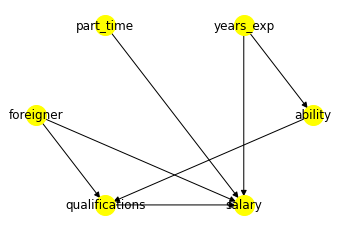

In [39]:
c_model=CausalModel(
        data = df,
        treatment='foreigner',
        outcome='salary',
        graph=gml_graph
        )
c_model.view_model()

In [40]:
df.head()

,foreigner,years_exp,ability,qualifications,part_time,real_salary,salary
0,1,20.818946,12.538903,27.075267,0,9685.512231,9679.155484
1,0,21.529966,11.633877,25.347100,0,9766.908029,9766.635171
2,0,9.349184,3.984518,7.995022,0,5186.649392,5178.852655
3,0,7.782030,4.123026,7.913627,1,5084.703794,5083.745952
4,1,28.939978,16.289900,33.208535,0,11382.703384,11360.280334


As we are interested in identifying potenital bias in the model it is worth printing out the average income grouped by the different values of the sensitive attribute:

In [41]:
df.groupby('foreigner')['salary'].mean()

foreigner
0    7856.455340
1    7005.666296
Name: salary, dtype: float64

In [42]:
(df[df['foreigner'] == 1].mean() - df[df['foreigner'] == 0].mean())['salary']

Here we clearly see that there is a difference between both values that seems to indicate that foreigners receive a much lower salary on average than locals. 

We're interested on certain path-specific effects though and for this it is useful to compute de natural direct effect (NDE) and the natural indirect effect (NIE):

In [43]:
identified_estimand = c_model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                       
────────────(Expectation(salary|ability,years_exp,part_time))
d[foreigner]                                                 
Estimand assumption 1, Unconfoundedness: If U→{foreigner} and U→salary then P(salary|foreigner,ability,years_exp,part_time,U) = P(salary|foreigner,ability,years_exp,part_time)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [44]:
identified_estimand_nde = c_model.identify_effect(estimand_type="nonparametric-nde", proceed_when_unidentifiable=True)
print(identified_estimand_nde)

Estimand type: nonparametric-nde

### Estimand : 1
Estimand name: mediation
Estimand expression:
Expectation(Derivative(salary|qualifications, [foreigner]))
Estimand assumption 1, Mediation: qualifications intercepts (blocks) all directed paths from foreigner to s,a,l,a,r,y except the path {foreigner}→{s,a,l,a,r,y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{foreigner} and U→{qualifications} then P(qualifications|foreigner,U) = P(qualifications|foreigner)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{qualifications} and U→salary then P(salary|qualifications, foreigner, U) = P(salary|qualifications, foreigner)



In [45]:
# Natural indirect effect (NDE)
causal_estimate_nde = c_model.estimate_effect(identified_estimand_nde,
                                              method_name="mediation.two_stage_regression",
                                              confidence_intervals=False,
                                              test_significance=False,
                                              method_params = {
                                                'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                                'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                              })
print(causal_estimate_nde)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-nde

### Estimand : 1
Estimand name: mediation
Estimand expression:
Expectation(Derivative(salary|qualifications, [foreigner]))
Estimand assumption 1, Mediation: qualifications intercepts (blocks) all directed paths from foreigner to s,a,l,a,r,y except the path {foreigner}→{s,a,l,a,r,y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{foreigner} and U→{qualifications} then P(qualifications|foreigner,U) = P(qualifications|foreigner)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{qualifications} and U→salary then P(salary|qualifications, foreigner, U) = P(salary|qualifications, foreigner)

## Realized estimand
(b: salary~foreigner+ability+years_exp+part_time+foreigner*ability+foreigner*years_exp+foreigner*part_time) - ((b: qualifications~foreigner+ability+years_exp+part_time+foreigner*ability+foreigner*years_exp+foreigner*part_time)*(b: salary~qualifications+ability+years_exp+part_time+fo

Here it is worth noting that the NDE is very close to the true parameter (-500) used to produce the direct effect between the sensitive attribute and the outcome in the underlying data generating process.

In [46]:
identified_estimand_nie = c_model.identify_effect(estimand_type="nonparametric-nie", proceed_when_unidentifiable=True)
print(identified_estimand_nie)

Estimand type: nonparametric-nie

### Estimand : 1
Estimand name: mediation
Estimand expression:
Expectation(Derivative(salary, [qualifications])*Derivative([qualifications], 
[foreigner]))
Estimand assumption 1, Mediation: qualifications intercepts (blocks) all directed paths from foreigner to s,a,l,a,r,y except the path {foreigner}→{s,a,l,a,r,y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{foreigner} and U→{qualifications} then P(qualifications|foreigner,U) = P(qualifications|foreigner)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{qualifications} and U→salary then P(salary|qualifications, foreigner, U) = P(salary|qualifications, foreigner)



In [47]:
# Natural indirect effect (NIE)
causal_estimate_nie = c_model.estimate_effect(identified_estimand_nie,
                                        method_name="mediation.two_stage_regression",
                                       confidence_intervals=False,
                                       test_significance=False,
                                        method_params = {
                                            'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                            'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                        }
                                       )
print(causal_estimate_nie)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-nie

### Estimand : 1
Estimand name: mediation
Estimand expression:
Expectation(Derivative(salary, [qualifications])*Derivative([qualifications], 
[foreigner]))
Estimand assumption 1, Mediation: qualifications intercepts (blocks) all directed paths from foreigner to s,a,l,a,r,y except the path {foreigner}→{s,a,l,a,r,y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{foreigner} and U→{qualifications} then P(qualifications|foreigner,U) = P(qualifications|foreigner)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{qualifications} and U→salary then P(salary|qualifications, foreigner, U) = P(salary|qualifications, foreigner)

## Realized estimand
(b: qualifications~foreigner+ability+years_exp+part_time+foreigner*ability+foreigner*years_exp+foreigner*part_time)*(b: salary~qualifications+ability+years_exp+part_time+foreigner+qualifications*ability+qualifications*years_exp+qualifications*part_ti

This estimate corresponds to the indirect effect of the sensitive attribute on the outcome variable.

Next we will use the NDE, which in this case also corresponds to the PSE, to adjust the outputs:

In [49]:
df['adj_salary'] = df['salary']
df.loc[df['foreigner']==1, 'adj_salary'] += 498.24

In [50]:
df.groupby('foreigner')['salary'].mean().to_frame()

,salary
foreigner,
0,7856.455340
1,7005.666296


In [51]:
df.groupby('foreigner')['adj_salary'].mean().to_frame()

,adj_salary
foreigner,
0,7856.455340
1,7503.906296


Here we see that the general disparity has been reduced and the remaining gap could potenitally be attributed to fair bias.

Next we compare the root mean squared error between the real salary and a second model where the sensitive attribute has been eliminated (as proposed by the fairness by unawareness definition):

In [52]:
np.sqrt(mean_squared_error(df_test['real_salary'], df['adj_salary']))

In [53]:
regressor2 = RandomForestRegressor(max_depth=15)
regressor2.fit(df_train[['years_exp', 'ability', 'qualifications', 'part_time']], df_train['real_salary'])
preds2 = regressor2.predict(df_test[['years_exp', 'ability', 'qualifications', 'part_time']])
np.sqrt(mean_squared_error(df_test['real_salary'], preds2))

In [54]:
df['reg2_salary'] = preds2
df.groupby('foreigner')['reg2_salary'].mean().to_frame()

,reg2_salary
foreigner,
0,7770.626057
1,7341.637837


In general we see a similar root mean squared error for this simple example (although the fairness by unawareness does have a lower error). We also see a slightly smaller gap in the adjusted predictions.

### Testing

The `doWhy` algorithm also allows us to perform some additional checks to evaluate if the causal model we have created fits with the data sample we have

First we create an estimate that we can use for the different tests.

In [55]:
estimate = c_model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",target_units="ate")

1. **Radom Common Cause**: This test includes randomly drawn covariates and computes the analsysis again so that we can see if the estimate changes or not. Here the intuition is that if our causal model is correct, then we shouldn't see major changes in the estimate.

In [56]:
refute1_results=c_model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:-756.3137673929359
New effect:-756.321259842086



2. **Placebo Treatment Refuter**: This test assigns a covariate as the treatment randomly and computes the estimate again. In this case, the estimate should move close to zero if our assumptions are correct.

In [57]:
refute2_results=c_model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:-756.3137673929359
New effect:-2.7284841053187847e-12
p value:0.0



3. **Data Subset Refuter**: Finally, this test is similar to cross-validation and essentially computes the estimate multiple times for different subsets of the data. We shouldn't expect much difference if our assumptions are correct.

In [58]:
refute3_results=c_model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:-756.3137673929359
New effect:-756.0561130454894
p value:0.49



# Public dataset

This is our second practical example and here we use the public Adult Income dataset.

In [59]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving adult.data to adult.data
User uploaded file "adult.data" with length 3974305 bytes


In [68]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
           'marital_status', 'occupation', 'relationship', 'race', 'gender',
           'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
           'high_income']

cc = pd.read_csv('adult.data', names=col_names, skipinitialspace=True)
cc['high_income'] = (cc['high_income'].apply(lambda x: '>50K' in x)).astype(int)
cc['workclass'] = cc['workclass'].map({'?': 0, 'Never-worked': 1, 'Without-pay': 2, 'Private': 3, 'State-gov': 4, 
                                       'Self-emp-not-inc': 5, 'Local-gov': 6, 'Federal-gov': 7, 'Self-emp-inc': 8})

cc['education'] = cc['education'].map({'Preschool': 0, '1st-4th': 1, '5th-6th': 2, '7th-8th': 3, '9th': 4,'10th': 5,
                                       '11th': 6, '12th': 7, 'HS-grad': 8, 'Some-college': 9, 'Assoc-acdm': 10,
                                       'Assoc-voc': 11, 'Bachelors': 12, 'Masters': 13, 'Prof-school': 14, 'Doctorate': 15})

cc['marital_status'] = cc['marital_status'].map({'Never-married': 0, 'Separated': 1, 'Married-spouse-absent': 2, 'Widowed': 3, 'Divorced': 4, 
                                                 'Married-AF-spouse': 5, 'Married-civ-spouse': 6})

cc['occupation'] = cc['occupation'].map({'?': 3, 'Adm-clerical': 7, 'Armed-Forces': 4, 'Craft-repair': 9, 'Exec-managerial': 14,
                                         'Farming-fishing': 5, 'Handlers-cleaners': 2, 'Machine-op-inspct': 6, 'Other-service': 1,
                                         'Priv-house-serv': 0, 'Prof-specialty': 13, 'Protective-serv': 12, 'Sales': 10,
                                         'Tech-support': 11, 'Transport-moving': 8})

cc['race'] = (cc['race'].apply(lambda x: 'White' in x)).astype(int)
cc['gender'] = (cc['gender'].apply(lambda x: 'Male' in x)).astype(int)

cc.drop(['fnlwgt', 'relationship', 'native_country', 'capital_gain', 'capital_loss'], axis=1, inplace=True)
cc.head()

,age,workclass,education,education_num,marital_status,occupation,race,gender,hours_per_week,high_income
0,39,4,12,13,0,7,True,1,40,0
1,50,5,12,13,6,14,True,1,13,0
2,38,3,8,9,4,2,True,1,40,0
3,53,3,6,7,6,2,False,1,40,0
4,28,3,12,13,6,13,False,0,40,0


Just like in the previous example, we can start by printing out the average values of the outcome variable grouped by the different values of the sensitive attribute (in this case race):

In [69]:
cc.groupby('race')['high_income'].mean().to_frame()

,high_income
race,
False,0.152582
True,0.255860


Once again we see a difference. In this case it would seem like white people have a higher probability of having a high income compared to black and other races.

## Train a machine learning model

In this case the output variable is binary, so we will use a Random Forest classifier

In [70]:
X_train, X_test, y_train, y_test = train_test_split(cc.iloc[:, :-1], cc['high_income'], test_size=0.33, random_state=42)

In [71]:
clf = RandomForestClassifier(max_depth=8, random_state=356)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, random_state=356)

In [72]:
clf.score(X_test, y_test)

In the previous example we defined the underlying linear functions and we were only interested in the direct effect. In this case we are interested in specific paths so we will use linear regressions to obtain the parameters describing each of the variables and a logistic regression for the output variable:

In [79]:
# M
lm = sm.OLS(X_train['marital_status'], sm.tools.add_constant(X_train[['gender','age','race']].astype(int))).fit()
theta_m = lm.params['const']
theta_s_m = lm.params['gender']
theta_a_m = lm.params['age']
theta_r_m = lm.params['race']

# E
lm = sm.OLS(X_train['education'], sm.tools.add_constant(X_train[['gender','age','race','marital_status']].astype(int))).fit()
theta_e = lm.params['const']
theta_s_e = lm.params['gender']
theta_m_e = lm.params['marital_status']
theta_a_e = lm.params['age']
theta_r_e = lm.params['race']

# W1
lm = sm.OLS(X_train['occupation'], sm.tools.add_constant(X_train[['gender','age','race','marital_status','education']].astype(int))).fit()
theta_w1 = lm.params['const']
theta_s_w1 = lm.params['gender']
theta_m_w1 = lm.params['marital_status']
theta_e_w1 = lm.params['education']
theta_a_w1 = lm.params['age']
theta_r_w1 = lm.params['race']

# W2
lm = sm.OLS(X_train['hours_per_week'], sm.tools.add_constant(X_train[['gender','age','race','marital_status','education']].astype(int))).fit()
theta_w2 = lm.params['const']
theta_s_w2 = lm.params['gender']
theta_m_w2 = lm.params['marital_status']
theta_e_w2 = lm.params['education']
theta_a_w2 = lm.params['age']
theta_r_w2 = lm.params['race']

# W3
lm = sm.OLS(X_train['workclass'], sm.tools.add_constant(X_train[['gender','age','race','marital_status','education']].astype(int))).fit()
theta_w3 = lm.params['const']
theta_s_w3 = lm.params['gender']
theta_m_w3 = lm.params['marital_status']
theta_e_w3 = lm.params['education']
theta_a_w3 = lm.params['age']
theta_r_w3 = lm.params['race']

# Y
lm = sm.Logit(y_train, sm.tools.add_constant(X_train[['gender','age','race','marital_status','education',
                                                                     'occupation', 'hours_per_week','workclass']].astype(int))).fit()
theta_y = lm.params['const']
theta_s_y = lm.params['gender']
theta_m_y = lm.params['marital_status']
theta_e_y = lm.params['education']
theta_a_y = lm.params['age']
theta_r_y = lm.params['race']
theta_w1_y = lm.params['occupation']
theta_w2_y = lm.params['hours_per_week']
theta_w3_y = lm.params['workclass']

Optimization terminated successfully.
         Current function value: 0.367719
         Iterations 8


With this we can use the parameters according to the calculations found in the paper to calculate the PSE.

Below we see the PSE if we had included the influence through marital status as unfair:

In [80]:
odds = np.exp(theta_r_y + theta_m_y*theta_r_m + theta_e_y*theta_m_e*theta_r_m+\
              theta_w1_y*(theta_m_w1*theta_r_m+theta_e_w1*theta_m_e*theta_r_m)+
              theta_w2_y*(theta_m_w2*theta_r_m+theta_e_w2*theta_m_e*theta_r_m)+
              theta_w3_y*(theta_m_w3*theta_r_m+theta_e_w3*theta_m_e*theta_r_m)
             )

print(odds)

1.4990941956506403


But, as mentioned earlier, we consider the effect through marital status to be fair which leads to this PSE:

In [ ]:
odds = np.exp(theta_r_y + theta_e_y*theta_r_e + \
              theta_w1_y*(theta_e_w1*theta_r_e) +
              theta_w2_y*(theta_e_w2*theta_r_e) +
              theta_w3_y*(theta_e_w3*theta_r_e))

print(odds)

1.3436812306525348


We can use the odds to compute the probability and also use this as a naive adjustment of the predictions from the ML model:

In [ ]:
print(odds/(1+odds))

0.5733208138883389


In [ ]:
prob_diff = 0.5 - odds/(1+odds)
prob_diff

In [ ]:
preds = clf.predict_proba(cc.iloc[700:, :-1])[:,1]
adj_preds = preds.copy()
adj_preds[cc.iloc[700:]['race']==0] -= prob_diff
adj_preds = (adj_preds > 0.5).astype(int)
preds = (preds > 0.5).astype(int)

In [ ]:
print('Probability of high income for non-white:', preds[cc.iloc[700:]['race']==0].mean().round(3))
print('Probability of high income for white:', preds[cc.iloc[700:]['race']==1].mean().round(3))

Probability of high income for non-white: 0.11
Probability of high income for white: 0.192


In [ ]:
print('Adjusted probability of high income for non-white:', adj_preds[cc.iloc[700:]['race']==0].mean().round(3))
print('Adjusted probability of high income for white:', adj_preds[cc.iloc[700:]['race']==1].mean().round(3))

Adjusted probability of high income for non-white: 0.149
Adjusted probability of high income for white: 0.192


In [ ]:
print('Accuracy raw predictions:', accuracy_score(cc.iloc[700:,-1], preds).round(3))

Accuracy raw predictions: 0.848


In [ ]:
print('Accuracy adjusted predictions:', accuracy_score(cc.iloc[700:,-1], adj_preds).round(3))

Accuracy adjusted predictions: 0.847


Here we also share the PSE taking gender as the sensitive attribute and considering the effect through marital status as unfair too:

In [ ]:
odds = np.exp(theta_s_y+theta_m_y*theta_s_m+theta_e_y*theta_m_e*theta_s_m+\
              theta_w1_y*(theta_m_w1*theta_s_m+theta_e_w1*theta_m_e*theta_s_m)+
              theta_w2_y*(theta_m_w2*theta_s_m+theta_e_w2*theta_m_e*theta_s_m)+
              theta_w3_y*(theta_m_w3*theta_s_m+theta_e_w3*theta_m_e*theta_s_m)
             )

print(odds)

3.4013795654050774


This result matches the results found by Nabi & Shpitser in "Fair Inference on Outcomes"